In [1]:
import numpy as np
import glob

from annoy import AnnoyIndex

import torch
import torch.nn as nn

from torchsummary import summary

import matplotlib.pyplot as plt

In [2]:
bbEmbeddingPath = "testrep/BubbleBobble"

In [3]:
columnRefArray = np.array([i+1 for i in range(13) for j in range(12)])

In [4]:
#bbEmbeddingPaths = sorted(glob.glob("testrep/BubbleBobble/level*.npy"))
bbEmbeddingPaths = sorted(glob.glob("/home/surfytom/Projects/Dissertation/Repos/TileEmbeddingDissertation/data/unified_rep/bubble_bobble/round*.pickle"))

In [5]:
import pickle

def get_pickle(pickle_path):
    '''
    This function loads the pickle file
    
    Input
    pickle_path: path of the pickle file
    Output
    Loads and returns the stored pickle file
    
    '''
    with open(pickle_path, "rb") as handle:
        level_pickle = pickle.load(handle)
    return level_pickle

In [6]:
N = 78

sosArray = np.ones(shape=(1, 256)) * 9
eosArray = np.ones(shape=(1, 256)) * 5

xTrain = []
xTrainHotColumnRef = []
yTrain = []
xTrainTargetIn = []

columnRef = []
for i, levelEmbeddingPath in enumerate(bbEmbeddingPaths[:100]):

    #levelEmbeddingArray = np.load(levelEmbeddingPath)
    levelEmbeddingArray = get_pickle(levelEmbeddingPath)

    for j in range(len(levelEmbeddingArray) - N):

        padLength = N - j

        dataI = np.concatenate((np.zeros(shape=(padLength, 256)), levelEmbeddingArray[:j]), axis=0)

        dataT = levelEmbeddingArray[j:j+N]
        targetIn = np.concatenate((sosArray, dataT))
        targetOut = np.concatenate((dataT, eosArray))

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for j in range(N): dataC[j][int(levelIdx[j])] = 1

        columnRef.append(dataC)
        xTrain.append(dataI)
        xTrainTargetIn.append(targetIn)
        yTrain.append(targetOut)

xTrain = np.array(xTrain)
xTrainTargetIn = np.array(xTrainTargetIn)
yTrain = np.array(yTrain)
columnRef = np.array(columnRef)

In [94]:
class LSTMModel(nn.Module):

    def __init__(self, debug=False):
        super().__init__()

        self.histLSTM = nn.LSTM(256, 128, batch_first=True)
        self.colLSTM = nn.LSTM(256, 128, batch_first=True)

        self.textLSTM = nn.LSTM(256, 128, batch_first=True)
        self.infTextLSTM = nn.LSTM(256, 128, batch_first=True)

        self.outputLayer = nn.Linear(128, 256)

    def forward(self, xHist, xText, xCol):
        
        histOut, (histH, histC) = self.histLSTM(xHist)

        #print(f"hist out shape b4: {histOut.size()}")
        #histOut = histOut[-1, :, :]
        #print(f"hist out shape b4: {histOut.size()}")

        colOut, (colH, colC) = self.colLSTM(xCol)

        #colOut = colOut[:, -1]

        hiddenAdd = torch.add(histH, histC)
        channelAdd = torch.add(colH, colC)

        #textOut, (textH, textC) = self.textLSTM(xText, (hiddenAdd, channelAdd)) if self.training else self.infTextLSTM(xText, (hiddenAdd, channelAdd))
        textOut, (textH, textC) = self.textLSTM(xText, (hiddenAdd, channelAdd))

        # print(f"text out size b4: {textOut.size()}")
        # if textOut.ndim == 2:
        #     textOut = textOut[-1, :]
        # else:
        #     textOut = textOut[:, -1, :]
        # print(f"text out size after: {textOut.size()}")

        output = nn.functional.tanh(self.outputLayer(textOut))
        
        return output
    
    def eval(self):

        # Sets up the weights of the inference lstm layer for text input
        self.infTextLSTM._flat_weights[0] = self.textLSTM._flat_weights[0][:, :78].clone().detach()
        self.infTextLSTM._flat_weights[1:] = [weightArray.clone().detach() for weightArray in self.textLSTM._flat_weights[1:]]

        super().eval()
        self.train(False)

In [95]:
def TrainModel(xTrain, xTrainTargetIn, yTrain, columnRef, epochs, batchSize):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = LSTMModel()
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, eps=1e-7)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)

    criterion = nn.MSELoss()

    model.to(device)
    model.train()

    losses = []

    print(f"xTrain b4 tensor shape: {xTrain.shape}")
    #xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[2], xTrain.shape[1])
    #xTrainTargetIn = xTrainTargetIn.reshape(xTrainTargetIn.shape[0], xTrainTargetIn.shape[2], xTrainTargetIn.shape[1])
    #yTrain = yTrain.reshape(yTrain.shape[0], yTrain.shape[2], yTrain.shape[1])
    #columnRef = columnRef.reshape(columnRef.shape[0], columnRef.shape[2], columnRef.shape[1])

    for i in range(epochs):

        losses.append([])

        for j in range(0, xTrain.shape[0], batchSize):
            
            xTrainTensor = torch.tensor(xTrain[j:j+batchSize], dtype=torch.float32).to(device)
            xTrainTargetInTensor = torch.tensor(xTrainTargetIn[j:j+batchSize], dtype=torch.float32).to(device)

            yTrainTensor = torch.tensor(yTrain[j:j+batchSize], dtype=torch.float32).to(device)

            columnRefTensor = torch.tensor(columnRef[j:j+batchSize], dtype=torch.float32).to(device)

            # print(xTrainTensor.shape)
            # print(xTrainTargetInTensor.shape)
            # print(yTrainTensor.shape)
            # print(columnRefTensor.shape)

            #print(f"xTrain size: {xTrainTensor.size()}")

            yPred = model(xTrainTensor, xTrainTargetInTensor, columnRefTensor)
            
            #print(f"yPred size: {yPred.size()}")
            #print(f"yTruth size: {yTrainTensor.size()}")
            loss = criterion(yPred, yTrainTensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i].append(loss.cpu().detach().item())

        print(f"Epoch {i}: loss {sum(losses[i])/len(losses[i])}")
    
    return model

In [101]:
model = TrainModel(xTrain, xTrainTargetIn, yTrain, columnRef, 25, 32)

xTrain b4 tensor shape: (7410, 78, 256)
Epoch 0: loss 0.5197300105516253
Epoch 1: loss 0.4738388828419406
Epoch 2: loss 0.45767136444819384
Epoch 3: loss 0.44870393479178694
Epoch 4: loss 0.440755698701431
Epoch 5: loss 0.43543733694943887
Epoch 6: loss 0.4219437539577484
Epoch 7: loss 0.3708354626493207
Epoch 8: loss 0.33500500331664906
Epoch 9: loss 0.32480694726109505
Epoch 10: loss 0.32026106716486913
Epoch 11: loss 0.31407337706407595
Epoch 12: loss 0.31036296730925295
Epoch 13: loss 0.3079593886203807
Epoch 14: loss 0.30576422688519134
Epoch 15: loss 0.3042409149608735
Epoch 16: loss 0.30222908587291325
Epoch 17: loss 0.3001848418779414
Epoch 18: loss 0.2983534878826347
Epoch 19: loss 0.29676718341893166
Epoch 20: loss 0.2953244636541811
Epoch 21: loss 0.2941006612803402
Epoch 22: loss 0.2929053544869711
Epoch 23: loss 0.29181745173088436
Epoch 24: loss 0.29098936407987414


In [50]:
total = 0
for name, param in model.named_parameters():
    print(f"{name:<24}: {param.numel():5}")
    total += param.numel()

print(f"Total Params: {total}")

histLSTM.weight_ih_l0   : 79872
histLSTM.weight_hh_l0   : 262144
histLSTM.bias_ih_l0     :  1024
histLSTM.bias_hh_l0     :  1024
colLSTM.weight_ih_l0    : 79872
colLSTM.weight_hh_l0    : 262144
colLSTM.bias_ih_l0      :  1024
colLSTM.bias_hh_l0      :  1024
textLSTM.weight_ih_l0   : 80896
textLSTM.weight_hh_l0   : 262144
textLSTM.bias_ih_l0     :  1024
textLSTM.bias_hh_l0     :  1024
infTextLSTM.weight_ih_l0: 79872
infTextLSTM.weight_hh_l0: 262144
infTextLSTM.bias_ih_l0  :  1024
infTextLSTM.bias_hh_l0  :  1024
outputLayer.weight      : 20224
outputLayer.bias        :    79
Total Params: 1397583


tileMap shape: (14820, 16, 16, 3)
embedMap shape: (14820, 256)
Maps Loaded
Initialised Tree
Building Tree
Tree Built
Annoy Map Trained
Random Start Point: 37
Input shape: (78, 78, 256)
input size: torch.Size([78, 256])
target shape: (78, 78, 256)
target size: torch.Size([78, 256])
column shape: (78, 78, 256)
column size: torch.Size([78, 256])
Running Model
next col size: (78, 256)
Input shape: (78, 78, 256)
input size: torch.Size([78, 256])
target shape: (78, 78, 256)
target size: torch.Size([78, 256])
column shape: (78, 78, 256)
column size: torch.Size([78, 256])
Running Model
next col size: (78, 256)
Input shape: (78, 78, 256)
input size: torch.Size([78, 256])
target shape: (78, 78, 256)
target size: torch.Size([78, 256])
column shape: (78, 78, 256)
column size: torch.Size([78, 256])
Running Model
next col size: (78, 256)
Input shape: (78, 78, 256)
input size: torch.Size([78, 256])
target shape: (78, 78, 256)
target size: torch.Size([78, 256])
column shape: (78, 78, 256)
column size:

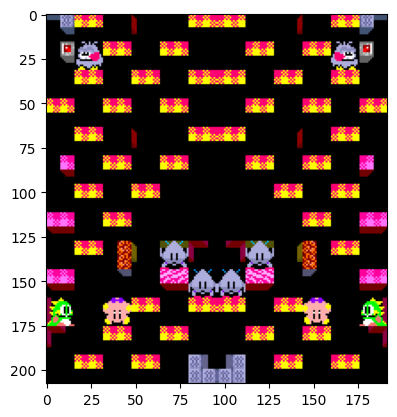

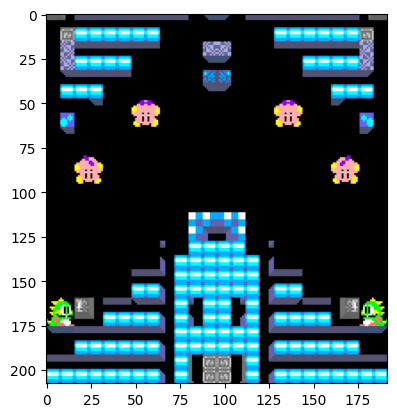

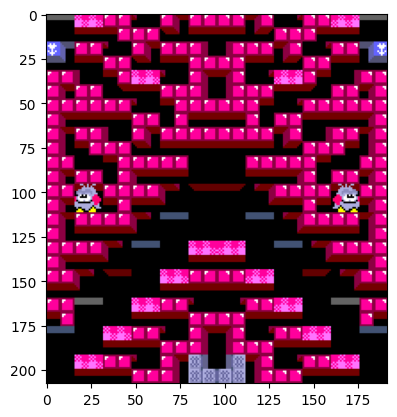

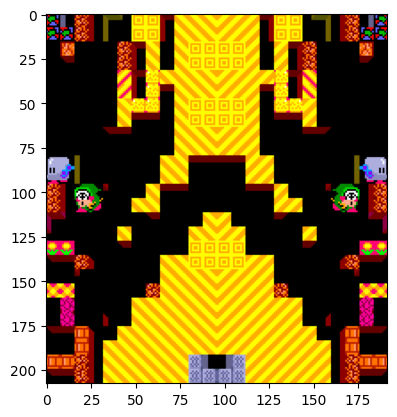

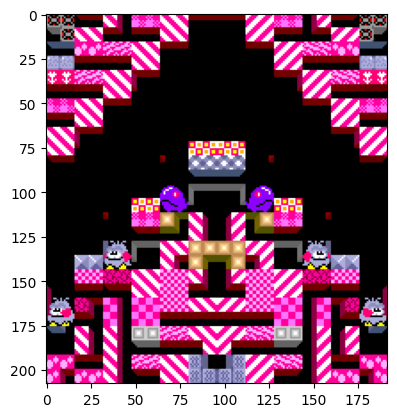

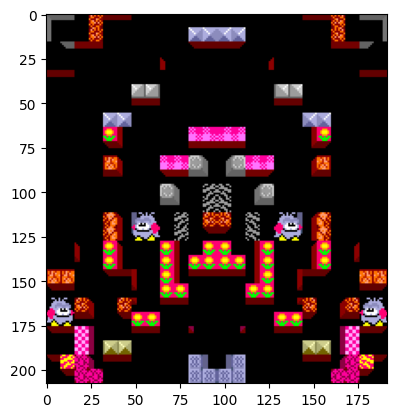

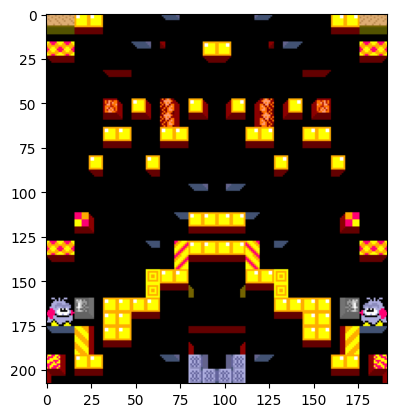

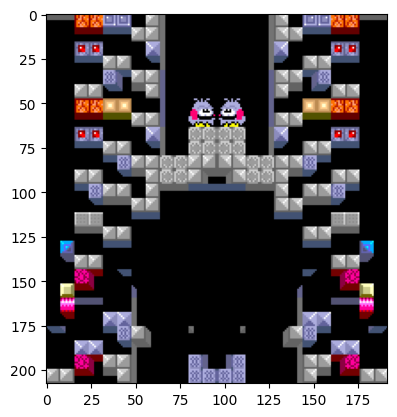

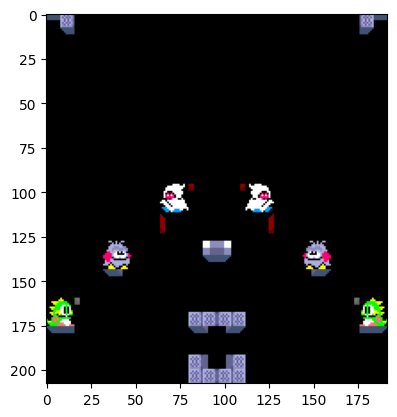

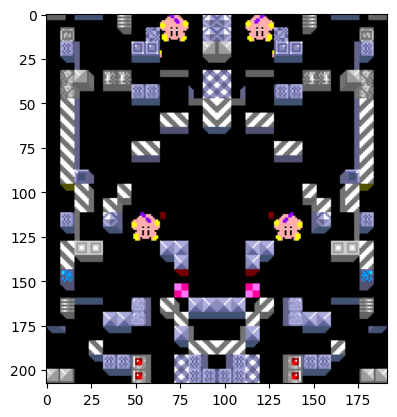

In [112]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
model.eval()

# tileMap = np.load("testrep/BubbleBobble/centerTiles.npy")
# embedMap = np.load("testrep/BubbleBobble/embeddings.npy")

tileMap = np.array(list(get_pickle("../data/unified_rep/bubble_bobble/"+"mappings/idx2tile.pickle").values()))
embedMap = np.array(list(get_pickle("../data/unified_rep/bubble_bobble/"+"mappings/idx2embed.pickle").values()))

print(f"tileMap shape: {tileMap.shape}")
print(f"embedMap shape: {embedMap.shape}")

print("Maps Loaded")

nnTree = AnnoyIndex(256, 'euclidean')

print("Initialised Tree")

#for i in range(embedMap.shape[0]): print(f"Added {i}th item to tree"), nnTree.add_item(i, embedMap[i])
for i in range(embedMap.shape[0]): nnTree.add_item(i, embedMap[i])

print("Building Tree")
nnTree.build(15)
print("Tree Built")

print("Annoy Map Trained")

N = 78
NLevels = 10

np.random.seed(1)
randStartPoint = np.random.randint(0, len(bbEmbeddingPaths)-NLevels)
print(f"Random Start Point: {randStartPoint}")

for i, levelEmbeddingPath in enumerate(bbEmbeddingPaths[randStartPoint:randStartPoint+NLevels]):

    input = []
    column = []
    target = []

    #levelEmbeddingArray = np.load(levelEmbeddingPath)
    levelEmbeddingArray = get_pickle(levelEmbeddingPath)

    for j in range(len(levelEmbeddingArray) - N):

        padLength = N - j

        dataI = np.concatenate((np.zeros(shape=(padLength, 256)), levelEmbeddingArray[:j]), axis=0)

        dataT = levelEmbeddingArray[j:j+N]

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for j in range(N): dataC[j][int(levelIdx[j])] = 1

        column.append(dataC)
        input.append(dataI)
        target.append(dataT)

    input = np.array(input)
    print(f"Input shape: {input.shape}")
    #input = torch.tensor(input[0].reshape(256, N), dtype=torch.float32).to(device)
    input = torch.tensor(input[0], dtype=torch.float32).to(device)
    print(f"input size: {input.size()}")

    target = np.array(target)
    print(f"target shape: {target.shape}")
    #target = torch.tensor(target[0].reshape(256, N), dtype=torch.float32).to(device)
    target = torch.tensor(target[0], dtype=torch.float32).to(device)
    print(f"target size: {target.size()}")

    column = np.array(column)
    print(f"column shape: {column.shape}")
    #column = torch.tensor(column[0].reshape(256, N), dtype=torch.float32).to(device)
    column = torch.tensor(column[0], dtype=torch.float32).to(device)
    print(f"column size: {column.size()}")

    print("Running Model")

    nextCol = model(input, target, column)
    nextCol = nextCol.cpu().detach().numpy()
    print(f"next col size: {nextCol.shape}")
    #nextCol = nextCol[:, :78].reshape(6, 13, nextCol.shape[0]).transpose(1, 0, 2)
    nextCol = nextCol.reshape(6, 13, nextCol.shape[1]).transpose(1, 0, 2)

    levelImage = np.zeros(shape=(nextCol.shape[0] * 16, nextCol.shape[1] * 16, 3), dtype=np.uint8)

    for t, row in enumerate(nextCol):
        for j, embedding in enumerate(row):

            nearestEmbedding = nnTree.get_nns_by_vector(embedding, 2, search_k=-1, include_distances=False)[0]
            tileImage = tileMap[nearestEmbedding]

            levelImage[t*16 : t*16+16, j*16 : j*16+16, :] = tileImage

    levelImage = np.concatenate([levelImage, np.fliplr(levelImage)], axis=1)

    plt.figure()
    plt.imshow(levelImage)